## Predicting Engine Failure By Sensor Data and time since start

Because predictive maintenance is of high importance due to repair and rework costs, saving money by predicting failures and by extending the life of a product by pushing it to an acceptable limit is extremely important. This investigation using a data set of aircraft engine failures will prove as a demo of capabilities for predictive maintenance.

### Load Data

In [1]:
import pandas as pd

In [2]:
engine_data = pd.read_csv("engine_data.txt",sep = " ", header = None)

In [4]:
indicator_names = ["sen" + str(x) for x in range(1,27)]
column_names = ["engine_id","day_of_operation"] + indicator_names

In [5]:
engine_data.columns = column_names

In [6]:
engine_data.head()

,engine_id,day_of_operation,sen1,sen2,sen3,sen4,sen5,sen6,sen7,sen8,...,sen17,sen18,sen19,sen20,sen21,sen22,sen23,sen24,sen25,sen26
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


The failure state of these engines isn't directly defined in the dataset and is instead defined by the last day that the engine is operational. We will have to go through each engine and find the last day where the engine is in operation then mark that as the failure day.

In [7]:
unique_engines = list(engine_data["engine_id"].unique())

In [8]:
failure_days = {}
for engine in unique_engines:
    current_engine_data = engine_data.loc[engine_data["engine_id"] == engine,:]
    failure_day = max(current_engine_data["day_of_operation"])
    failure_days[engine] = failure_day

In [9]:
days_till_failure = []
for index, row in engine_data.iterrows():
    engine_id = row["engine_id"]
    days_of_op = row["day_of_operation"]
    countdown = failure_days[engine_id] - days_of_op
    days_till_failure.append(countdown)
    
engine_data["days_till_failure"] = days_till_failure

We should now eliminate any columns that have a high propensity of null values. And if there are columns with a minimum of nulls, then we can replace those values with a line between the previous and next points to fill in.

In [10]:
engine_data.isnull().sum()

engine_id                0
day_of_operation         0
sen1                     0
sen2                     0
sen3                     0
sen4                     0
sen5                     0
sen6                     0
sen7                     0
sen8                     0
sen9                     0
sen10                    0
sen11                    0
sen12                    0
sen13                    0
sen14                    0
sen15                    0
sen16                    0
sen17                    0
sen18                    0
sen19                    0
sen20                    0
sen21                    0
sen22                    0
sen23                    0
sen24                    0
sen25                20631
sen26                20631
days_till_failure        0
dtype: int64

In [11]:
engine_data= engine_data.drop(["sen25", "sen26"], axis= 1)

This by comparison is a very clean data set. Because it's sensor data the only real issue we could potentially have to deal with is noise in our sensor signals. We will attempt to apply a filter to the sensors in a bit to try to gain more understanding from those sensors

## Investigating our Dependent Variable and Relationships

We should first gather a general understanding of acceptable values for engine failure to ensure that we do not have many outliers that can potentially skew some learning algorithms.

In [13]:
from matplotlib import pyplot as plt
import numpy as np
operation_days = list(failure_days.values())

Text(0.5,0,'Days')

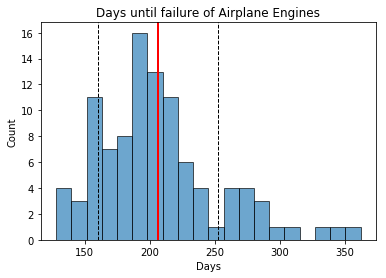

In [14]:
%matplotlib inline

plt.hist(operation_days, bins = 20, edgecolor = 'k', alpha = .65)
mean = np.mean(operation_days)
sd = np.std(operation_days)
plt.axvline(mean, color = 'r', linewidth = 2)
plt.axvline(mean+sd, color = 'k', linestyle = 'dashed', linewidth = 1)
plt.axvline(mean-sd, color = 'k', linestyle = 'dashed', linewidth = 1)
plt.title("Days until failure of Airplane Engines")
plt.ylabel("Count")
plt.xlabel("Days")

This above graph with a pretty standard distribution of days until failure this would give us a decent estimate of probability of lasting a certain number of days i.e. there is a 3% chance any engine will last more than mean + 3sd days. 

In [19]:
from scipy import stats
stats.describe(operation_days)

DescribeResult(nobs=100, minmax=(128, 362), mean=206.31, variance=2147.6504040404043, skewness=1.0159342583415127, kurtosis=1.113867529578351)

We see that the mean is 206 days with a non negligible amount of skew. Our distribution is slightly skewed

In [16]:
p_failure = []
operation_days = np.array(operation_days)
for i in range(1,351):
    prob_failure = len(operation_days[operation_days<=i])/len(operation_days) * 100
    p_failure.append(prob_failure)

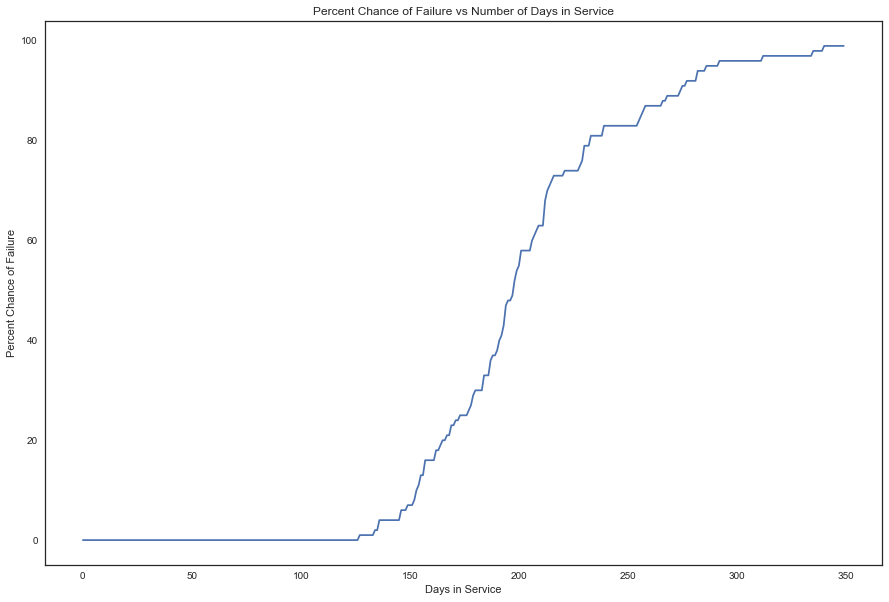

In [238]:
fig,ax= plt.subplots(figsize = (15,10))
plt.plot(p_failure)
plt.title("Percent Chance of Failure vs Number of Days in Service")
plt.xlabel("Days in Service")
plt.ylabel("Percent Chance of Failure")
plt.show()

Simplistically this would be a failure analysis graph, this could be enough information for some. You would
set a minimum threshold and just rework your engines when they approach that threshold. For example if
you wanted to rework an engine when there was a 20% chance of failure you would rework at approximately 
150 days. 

The only issue with this simplistic approach is that you may be wasting money by reworking too soon. Or in the offchance you
have a very poor working engine you may encounter the catastrophic failure of having waited too long. 
With sensor data we can get better information and be more precise with saying how long we think your engine has given 
certain information or saying if we think the engine will fail within the next n days given certain sensor information

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
lr = LinearRegression(normalize = True)

sensors = [x for x in engine_data.columns if "sen" in x]
days_and_sensors = sensors + ["day_of_operation"]

all_X = engine_data[days_and_sensors]
all_Y = engine_data["days_till_failure"]

selector = RFECV(lr, cv = 10)
selector.fit(all_X, all_Y)

In [21]:
selected_columns = all_X.columns[selector.support_]
selected_columns

Index(['sen19'], dtype='object')

Upon first investigation only one value comes out of the RFECV. This is quite odd when we have so many sensors.
We should investigate this column as well as all the other sensors to see which ones correlate the most and which
change or decline as you get closer to failure time

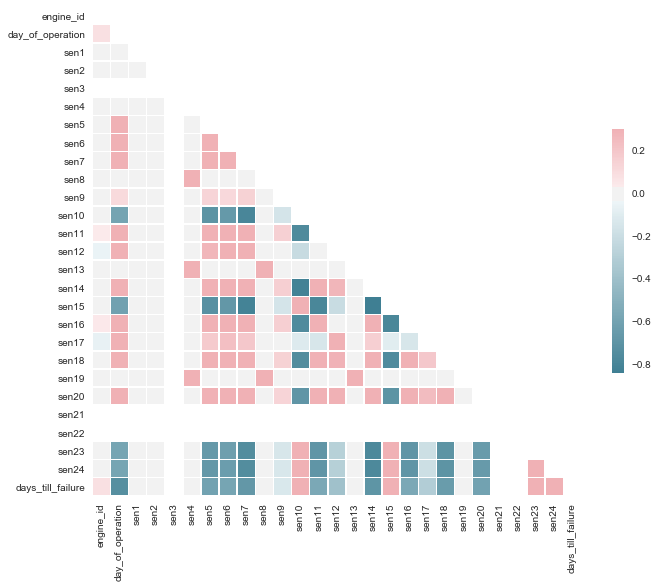

In [23]:
import seaborn as sns


def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    
plot_correlation_heatmap(engine_data)

We want things that are correlated heavily blue or heavily red, we also want to avoid features
that are heavily correlated with one another as to avoid adding unnecessary variance in our data set.

In [25]:
correlation_matrix = engine_data.corr()

In [26]:
days_till_failure_corrs = correlation_matrix["days_till_failure"]
key_correlations = days_till_failure_corrs.loc[abs(days_till_failure_corrs) > .5]

In [27]:
key_correlations

day_of_operation    -0.736241
sen5                -0.606484
sen6                -0.584520
sen7                -0.678948
sen10                0.657223
sen11               -0.563968
sen14               -0.696228
sen15                0.671983
sen16               -0.562569
sen18               -0.642667
sen20               -0.606154
sen23                0.629428
sen24                0.635662
days_till_failure    1.000000
Name: days_till_failure, dtype: float64

We see that day of operation has the highest correlation, so as the engine gets older it obviously gets closer to failure.
Let's look into the sensor data of these highly correlated features of an engine and see if the signals are quite noisy or not.

## Sensor Noise Reduction

In [29]:
first_engine = engine_data.loc[engine_data["engine_id"] == 1,:]

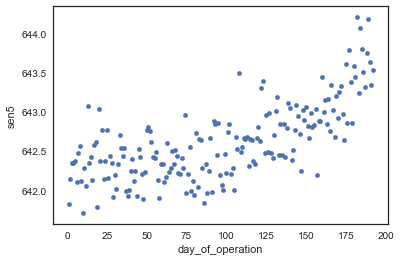

In [30]:
first_engine.plot("day_of_operation", "sen5", kind = "scatter")

We see there is a good amount of noise in the signal around the actual pattern of the data and we can attempt to do two methods:
* Noise reduction to find true signal (with a filter)
* Use a moving average of last 5 or 10 data points

In [ ]:
first_engine["sen5ma"] = first_engine['sen5'].rolling(10).mean()

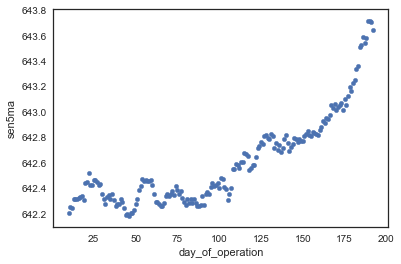

In [33]:
first_engine.plot("day_of_operation", "sen5ma", kind = "scatter")

We have now reduced a lot of the noise in our signal and see a much more consistent pattern except for at the start where we see
some oscillation in the signal.
Let's try noise reduction using a filter

In [35]:
first_engine.shape[0]

192

In [ ]:
from scipy.signal import savgol_filter
first_engine["sen5fil"] = savgol_filter(first_engine["sen5"],81,2)

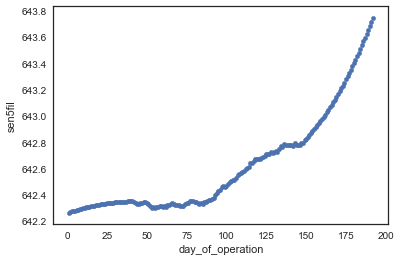

In [37]:
first_engine.plot("day_of_operation", "sen5fil", kind = "scatter")

This is a much cleaner output of a signal, maybe it's a tad bit too precise but it does capture the pattern we are looking for.
Let's take a look at some of the other sensors from our key sensors that correlated and check their signals for noise as well

In [39]:
key_sensors = [x for x in list(key_correlations.index) if "sen" in x]

In [41]:
def round_up_to_odd(f):
    f = int(np.ceil(f))
    return f + 1 if f % 2 == 0 else f


def filter_data(df, columns):
    unique_engines = list(df["engine_id"].unique())
    complete_df = pd.DataFrame()
    for engine in unique_engines:
        cur_engine = df.loc[df["engine_id"] == engine,:]
        window_size = round_up_to_odd(np.ceil(cur_engine.shape[0]/2))
        #print("Size of this engine's data frame")
        #print(cur_engine.shape[0])
        for col in columns:
            new_name = col+ "fil"
            filtered_column  = savgol_filter(cur_engine.loc[:,col],window_size,2)
            #print(len(filtered_column))
            cur_engine[new_name] = filtered_column
        complete_df = pd.concat([complete_df, cur_engine])
    
    return complete_df

In [42]:
first_engine = filter_data(first_engine, key_sensors)

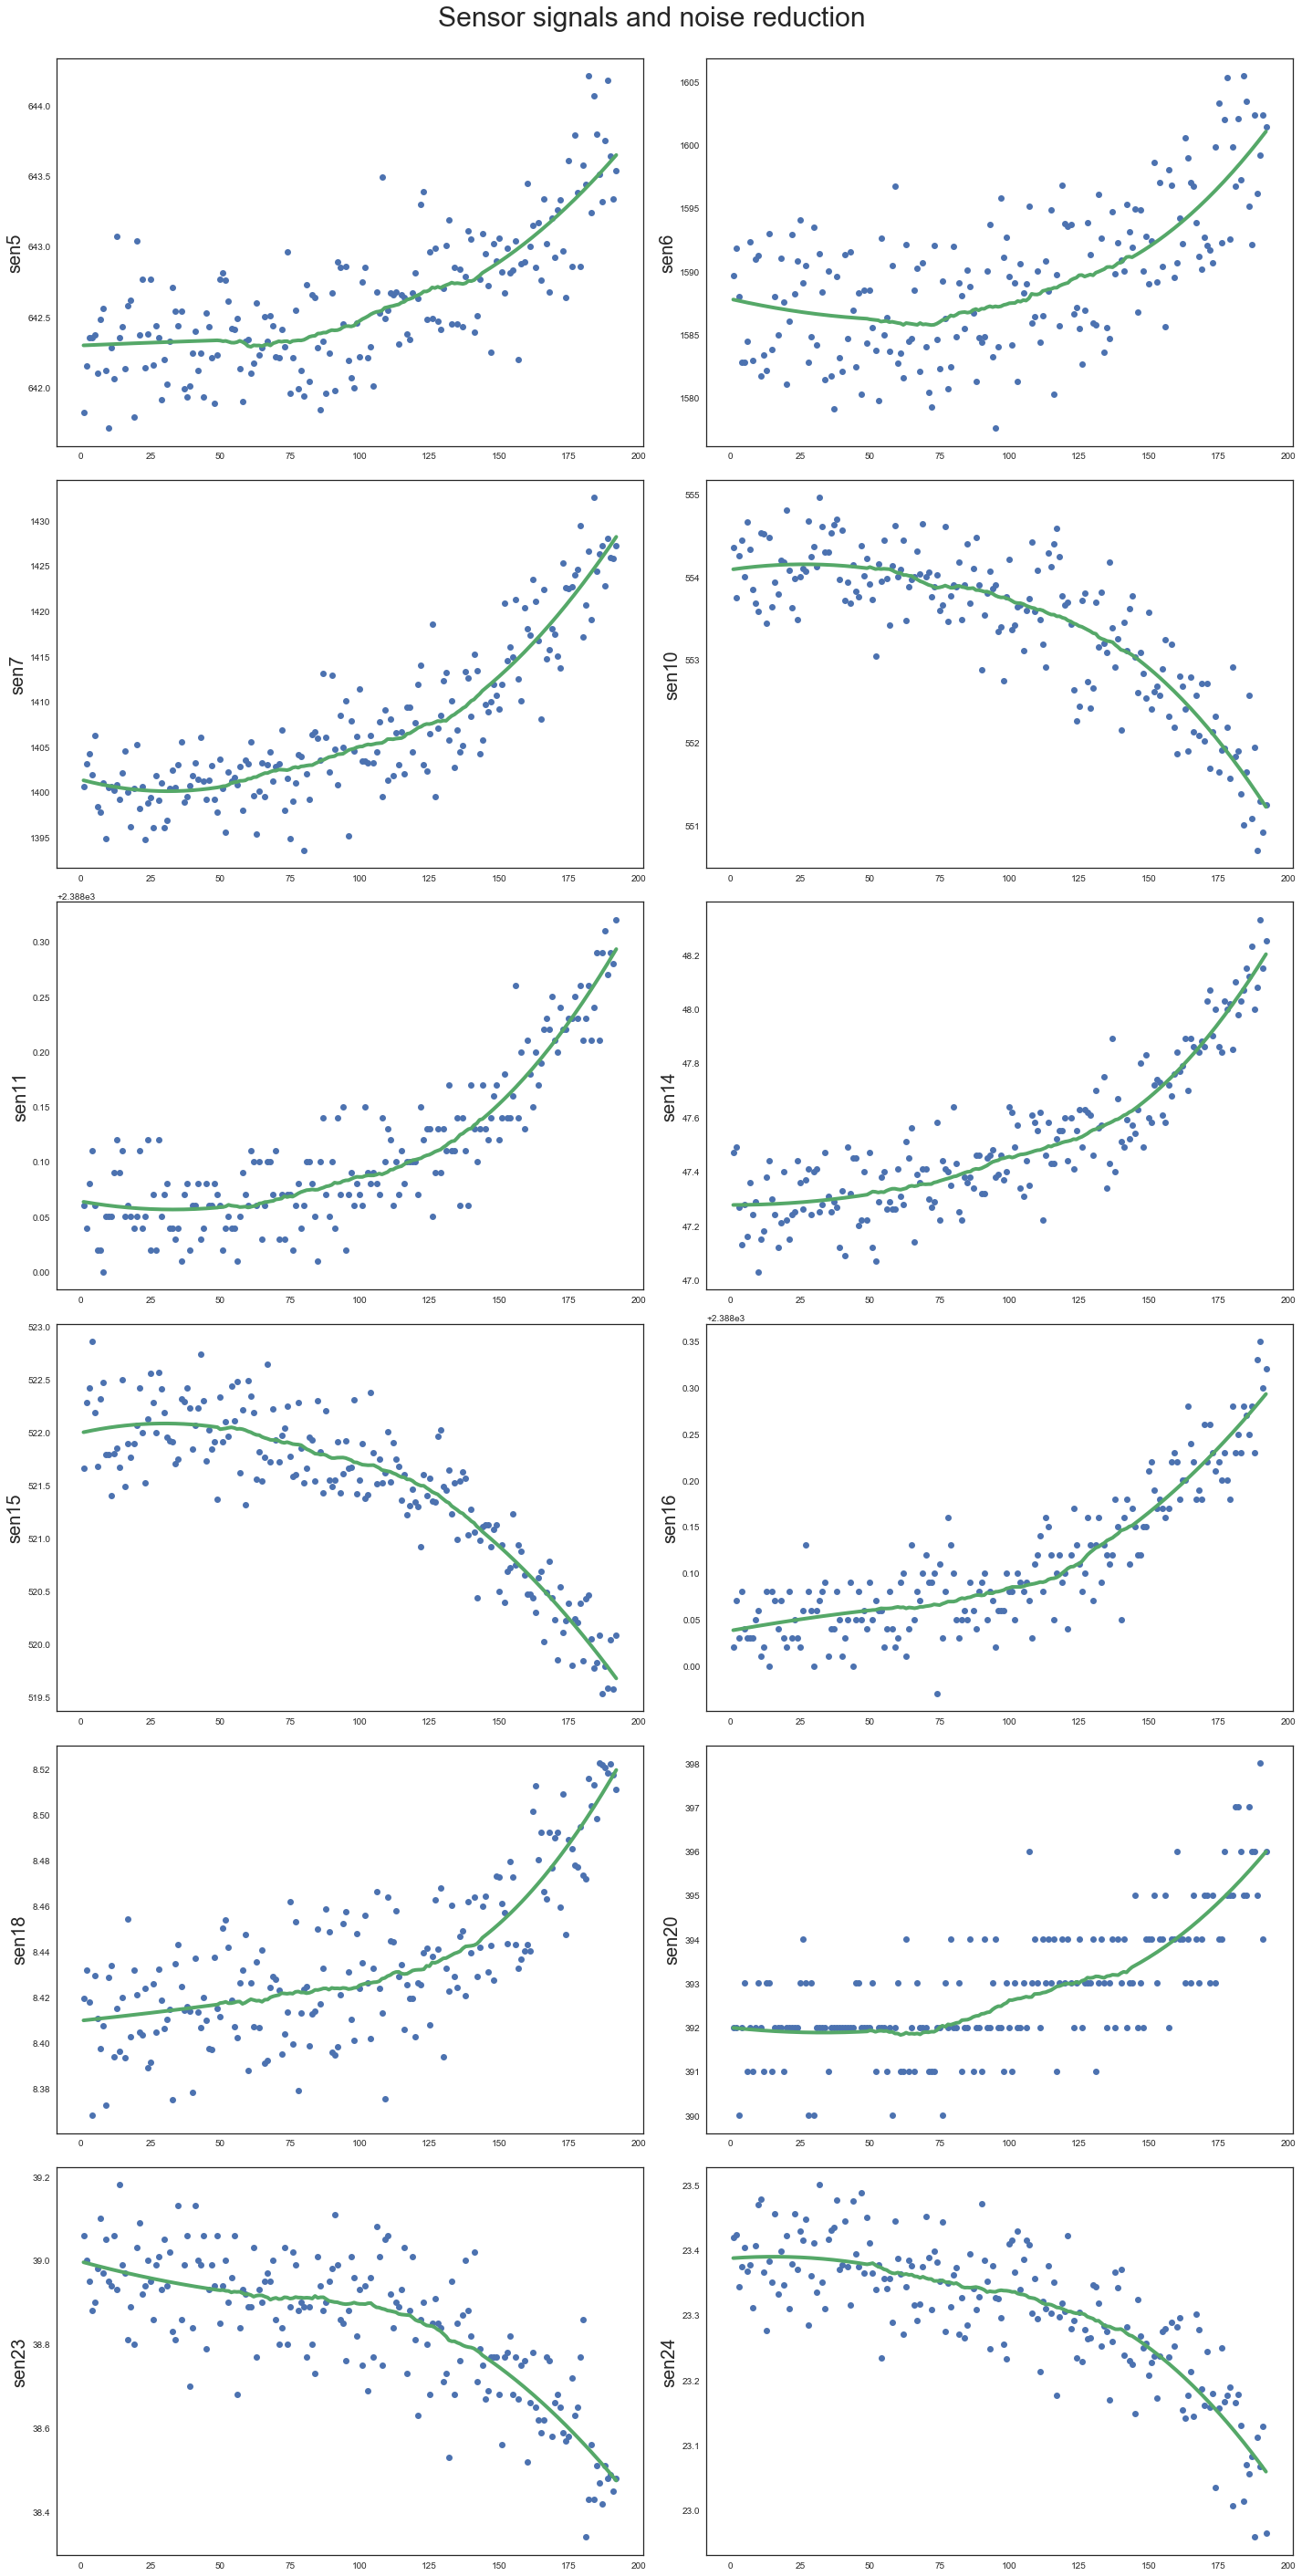

In [43]:
fig,ax= plt.subplots(figsize = (20,40))

for i in range(1,len(key_sensors)+1):
    plt.subplot(6,2,i)
    plt.plot(first_engine["day_of_operation"],first_engine[key_sensors[i-1]], "o")
    plt.plot(first_engine["day_of_operation"],first_engine[str(key_sensors[i-1] + "fil")], "-", linewidth = 4)
    plt.ylabel(key_sensors[i-1], fontsize = 20)
    
fig.suptitle("Sensor signals and noise reduction", fontsize = 30)
fig.tight_layout()
fig.subplots_adjust(top = .96)

Moving forward we will use the noise reduced signals from these specific key correlated sensors as well as the day into operation of the engine. The above graph shows that as we filter the signals down we see a true relationship with these sensors and the impending failure of the aircraft engine.

## Model Creation, Evaluation, and Feature Engineering

### Modeling Days Until Failure

In [ ]:
new_engine_data = filter_data(engine_data, key_sensors)

In [45]:
filtered_sensors = [x for x in new_engine_data.columns if "fil" in x]

In [46]:
key_columns = filtered_sensors + ["day_of_operation"]

In [ ]:
lr = LinearRegression()
all_X = new_engine_data[key_columns]
all_Y = new_engine_data["days_till_failure"]
selector = RFECV(lr, cv = 10)
selector.fit(all_X, all_Y)

In [48]:
selected_columns = all_X.columns[selector.support_]
selected_columns

Index(['sen5fil', 'sen6fil', 'sen7fil', 'sen10fil', 'sen11fil', 'sen14fil',
       'sen15fil', 'sen16fil', 'sen18fil', 'sen20fil', 'sen23fil', 'sen24fil',
       'day_of_operation'],
      dtype='object')

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, all_X, all_Y,scoring = "neg_mean_absolute_error", cv= 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

-31.62886099767193


In [50]:
scores = cross_val_score(lr, all_X[selected_columns], all_Y,scoring = "neg_mean_absolute_error", cv = 10)
mean_error_lr_features = scores.mean()
print(mean_error_lr_features)

-31.62886099767193


In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state = 1)
selector = RFECV(clf, cv = 10)
selector.fit(all_X, all_Y)

In [52]:
scores = cross_val_score(clf, all_X, all_Y,scoring = "neg_mean_absolute_error", cv= 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-28.321743800892058


In [53]:
selected_columns = all_X.columns[selector.support_]
selected_columns

scores = cross_val_score(clf, all_X[selected_columns], all_Y,scoring = "neg_mean_absolute_error",cv = 10)
mean_error_rf_features = scores.mean()
print(mean_error_rf_features)

-28.321743800892058


From looking at sensor data we see that most of the telling sensors are stagnant for an extended period then begin a quick rise
towards when it is approaching failure. This would give me reason to believe that our models have a hard time pinpointing a 
number of days until failure at the beginning of an engine's life but get better as you get closer to the failure and the sensor
begin to rapidly change. I'm going to discretely separate out some engines and attempt to discover if this is the case

In [100]:
num_test_engines = int(np.ceil(.3 * len(unique_engines)))
num_train_engines = int(len(unique_engines) - num_train_engines)

train_engines = np.random.choice(unique_engines,num_train_engines, replace = False)
test_engines = [x for x in unique_engines if x not in train_engines]

train_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(train_engines),:]
test_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(test_engines),:]

In [101]:
clf.fit(train_engine_data[key_columns], train_engine_data["days_till_failure"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [ ]:
test_engine_data["test_predictions"] = clf.predict(test_engine_data[key_columns])
test_engine_data.loc[:,"error"] = abs(test_engine_data.loc[:,"test_predictions"] - test_engine_data.loc[:,"days_till_failure"])
average_error_by_days = test_engine_data.groupby('day_of_operation')['error'].mean()


Text(0.5,0,'Days in Operation')

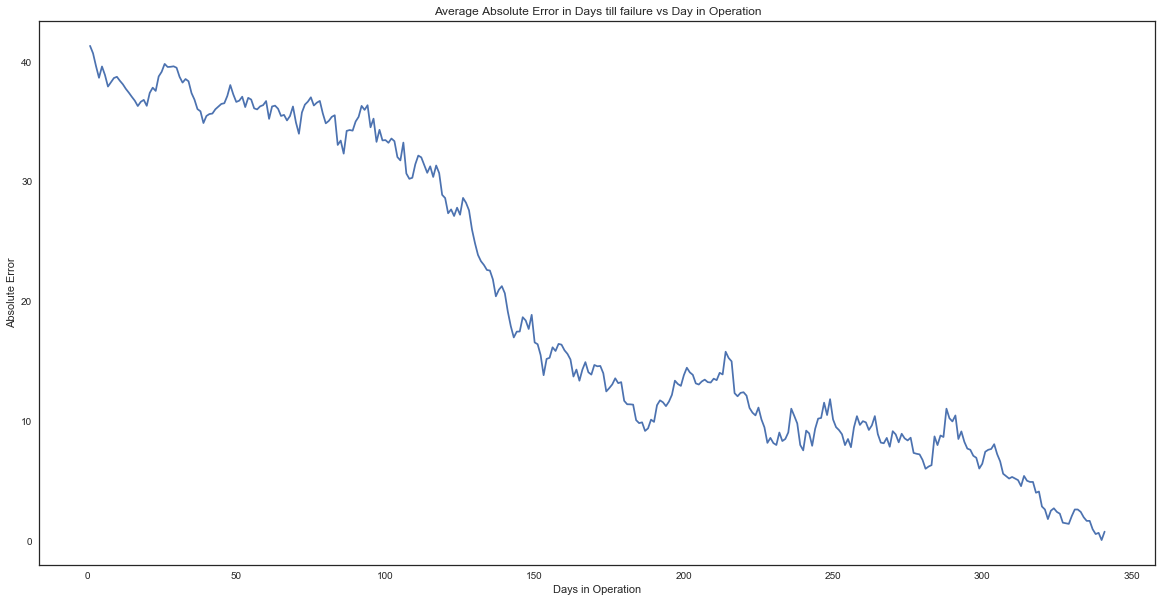

In [110]:
fig,ax= plt.subplots(figsize = (20,10))
plt.plot(average_error_by_days)
plt.title("Average Absolute Error in Days till failure vs Day in Operation")
plt.ylabel("Absolute Error")
plt.xlabel("Days in Operation")

We see that by showing the error as a function of days since operations we are honing in on how many days the engine 
has left and we get closer and closer to the right answer as we progress. We also see there is a sharp decline between 125 
and 150 days. This coincides with the period where the sensors start to take a drastic turn and display more properties 
that are indicative of an engine beginning to fail

We could also spend some time engineering features that look into the rate of change of the last 
few sensor values. i.e. the slope of the last 5/10/15 days of specific sensors to see if failure
is more close given a steeper slope instead of just knowing the value. Giving some time history to our model inputs tends to 
be quite helpful as a trend is usually more indicative than a single point. 


In [127]:
def calc_slope_for_row(i,df, sensor, count):
    final_value = df.iloc[i][sensor]
    if i == 0:
        return 0
    elif i < count:
        length = i
    else:
        length = count
    initial_value = df.iloc[i - length][sensor]
    slope = (final_value - initial_value)/length
    
    return slope

def calc_slope_for_engine(df, sensor_list, count):
    df = df.reset_index()
    for sensor in sensor_list:
        new_col_title = str(str(sensor) + "_slope")
        slopes = []
        for i, row in df.iterrows():
            #print(i)
            slopes.append(calc_slope_for_row(i,df,sensor,count))
        
        df[new_col_title] = slopes
    return df
    
def calc_slope_for_all(df, sensor_list, count):
    unique_engines = list(df["engine_id"].unique())
    complete_df = pd.DataFrame()
    for engine in unique_engines:
        cur_engine = df.loc[df["engine_id"] == engine,:]
        cur_engine = calc_slope_for_engine(cur_engine, sensor_list, count)
        complete_df = pd.concat([complete_df, cur_engine])
    return complete_df

In [131]:
new_engine_data = calc_slope_for_all(new_engine_data, filtered_sensors, 5)

In [132]:
slope_values = [x for x in new_engine_data.columns if "slope" in x]

In [134]:
key_columns = key_columns + slope_values

In [ ]:
lr = LinearRegression()
all_X = new_engine_data[key_columns]
all_Y = new_engine_data["days_till_failure"]
selector = RFECV(lr, cv = 10)
selector.fit(all_X, all_Y)

In [137]:
selected_columns = all_X.columns[selector.support_]
selected_columns

Index(['sen5fil', 'sen6fil', 'sen7fil', 'sen10fil', 'sen11fil', 'sen14fil',
       'sen15fil', 'sen16fil', 'sen18fil', 'sen20fil', 'sen23fil', 'sen24fil',
       'day_of_operation', 'sen5fil_slope', 'sen6fil_slope', 'sen7fil_slope',
       'sen10fil_slope', 'sen11fil_slope', 'sen14fil_slope', 'sen15fil_slope',
       'sen16fil_slope', 'sen18fil_slope', 'sen20fil_slope', 'sen23fil_slope',
       'sen24fil_slope'],
      dtype='object')

In [138]:
scores = cross_val_score(lr, all_X, all_Y,scoring = "neg_mean_absolute_error", cv= 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

-28.103932391947403


In [139]:
scores = cross_val_score(lr, all_X[selected_columns], all_Y,scoring = "neg_mean_absolute_error", cv = 10)
mean_error_lr_features = scores.mean()
print(mean_error_lr_features)

-28.103932391947403


In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state = 1)
selector = RFECV(clf, cv = 10)
selector.fit(all_X, all_Y)

In [141]:
scores = cross_val_score(clf, all_X, all_Y,scoring = "neg_mean_absolute_error", cv= 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-18.229796516324914


In [142]:
selected_columns = all_X.columns[selector.support_]

scores = cross_val_score(clf, all_X[selected_columns], all_Y,scoring = "neg_mean_absolute_error",cv = 10)
mean_error_rf_features = scores.mean()
print(mean_error_rf_features)

-18.229796516324914


In [143]:
num_test_engines = int(np.ceil(.3 * len(unique_engines)))
num_train_engines = int(len(unique_engines) - num_train_engines)

train_engines = np.random.choice(unique_engines,num_train_engines, replace = False)
test_engines = [x for x in unique_engines if x not in train_engines]

train_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(train_engines),:]
test_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(test_engines),:]

In [144]:
clf.fit(train_engine_data[key_columns], train_engine_data["days_till_failure"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [ ]:
test_engine_data["test_predictions"] = clf.predict(test_engine_data[key_columns])
test_engine_data.loc[:,"error"] = abs(test_engine_data.loc[:,"test_predictions"] - test_engine_data.loc[:,"days_till_failure"])
average_error_by_days = test_engine_data.groupby('day_of_operation')['error'].mean()


Text(0.5,0,'Days in Operation')

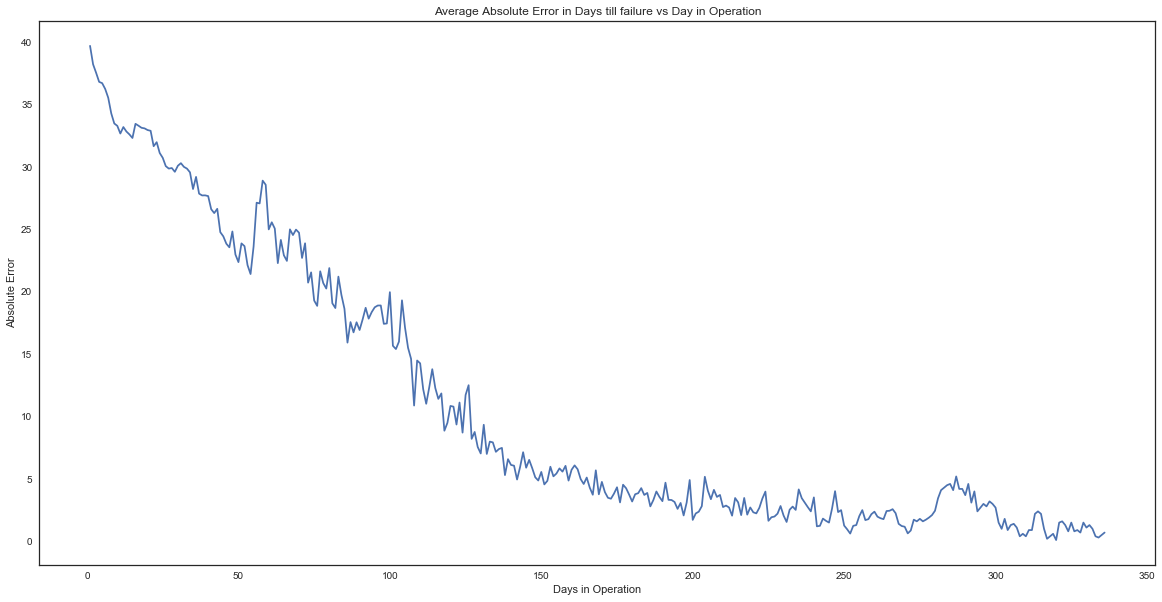

In [146]:
fig,ax= plt.subplots(figsize = (20,10))
plt.plot(average_error_by_days)
plt.title("Average Absolute Error in Days till failure vs Day in Operation")
plt.ylabel("Absolute Error")
plt.xlabel("Days in Operation")

Using the graph above we see that as our sensors start to report values that change, we start to hone in on our failure
date. After approximately 100 days, our error is less than 10 days and after 150 we are within 5 days. If we compare that with
the information at the start where we just investigated average time to failure and probability of failure after x days, we see
that before you are even 10% probable of failure this model can accurately predict the number of days remaining 
within 5 days. This incorporates a change in sensor that our previous attempt did not. This reduced our overall error by 10 
days and reduced our error as we approach the critical stages of the engines life by half. It appears that slope information
is quite critical to accurately predicting the remaining life.

### Modeling Probability of Failure in X Days

That gave us a pretty good handle on the situation where we know all the sensor data and the number of days the
engine has been active to tell how many more days we think it will be operational
in a more broad sense the better situation is to give windows, i.e. is failure in 15 days imminent
or 30 days imminent

Let's attempt this sort of modeling. I.e. if 15 days is imminent then one would think service is necessary

In [149]:
within_15_days = [1 if x <= 15 else 0 for x in new_engine_data["days_till_failure"]]
within_30_days = [1 if x <= 30 else 0 for x in new_engine_data["days_till_failure"]]
within_5_days = [1 if x <= 5 else 0 for x in new_engine_data["days_till_failure"]]

In [150]:
new_engine_data["within_30_days"] = within_30_days
new_engine_data["within_15_days"] = within_15_days
new_engine_data["within_5_days"] = within_5_days

In [151]:
from sklearn.linear_model import LogisticRegression

Here we are working with classification so logisticRegression seems like a good place to start followed
by potentially a neural network

In [153]:
all_X = new_engine_data[key_columns]
all_X.columns

Index(['sen5fil', 'sen6fil', 'sen7fil', 'sen10fil', 'sen11fil', 'sen14fil',
       'sen15fil', 'sen16fil', 'sen18fil', 'sen20fil', 'sen23fil', 'sen24fil',
       'day_of_operation', 'sen5fil_slope', 'sen6fil_slope', 'sen7fil_slope',
       'sen10fil_slope', 'sen11fil_slope', 'sen14fil_slope', 'sen15fil_slope',
       'sen16fil_slope', 'sen18fil_slope', 'sen20fil_slope', 'sen23fil_slope',
       'sen24fil_slope'],
      dtype='object')

In [154]:
lr = LogisticRegression()
all_Y = new_engine_data["within_15_days"]
scores = cross_val_score(lr,all_X , all_Y, cv= 10)
accuracy = scores.mean()
print(accuracy)

0.9809993912680788


In [155]:
lr = LogisticRegression()
all_Y = new_engine_data["within_30_days"]
scores = cross_val_score(lr,all_X , all_Y, cv= 10)
accuracy = scores.mean()
print(accuracy)

0.9660217443175625


In [156]:
lr = LogisticRegression()
all_Y = new_engine_data["within_5_days"]
scores = cross_val_score(lr,all_X , all_Y, cv= 10)
accuracy = scores.mean()
print(accuracy)

0.9897243139553671


Although we averaged around 18 days of error when creating a model that was attempting to predict the continuous value
of number of days until failure we see that we can quite accurately predict if an object will fail within the next 
15 or 30 days. This would give the airline enough information to stop work and repair the engine. let's try using the auto
select feature and see if we can get even more accurate

It would be helpful to see a confusion matrix of our set to see how we do on both sets of data the engines near failure and
the engines that are not near failure.

In [159]:
num_test_engines = int(np.ceil(.3 * len(unique_engines)))
num_train_engines = int(len(unique_engines) - num_train_engines)

train_engines = np.random.choice(unique_engines,num_train_engines, replace = False)
test_engines = [x for x in unique_engines if x not in train_engines]

train_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(train_engines),:]
test_engine_data = new_engine_data.loc[new_engine_data["engine_id"].isin(test_engines),:]

[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

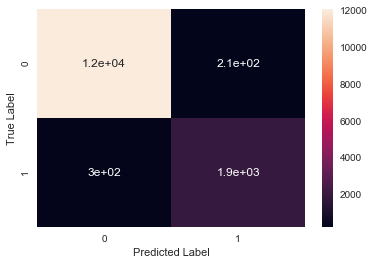

In [193]:
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_30_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_30_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [194]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
precision = precision_score(test_engine_data["within_30_days"], predictions)
recall = recall_score(test_engine_data["within_30_days"], predictions)
roc = roc_auc_score(test_engine_data["within_30_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 90.10091302258529%
Recall: 86.40552995391705%
ROC: 0.9236126170898465


Let's look at the confusion matrices for within 15 days and within 5 days to see how those compare. 86% recall is good, but
that means we did not catch 14% of the time when engines were within 30 days of failure and we said they were not

[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

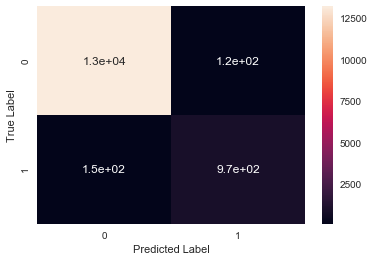

In [195]:
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_15_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_15_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [196]:
precision = precision_score(test_engine_data["within_15_days"], predictions)
recall = recall_score(test_engine_data["within_15_days"], predictions)
roc = roc_auc_score(test_engine_data["within_15_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 89.27589367552704%
Recall: 86.96428571428572%
ROC: 0.930419622702354


[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

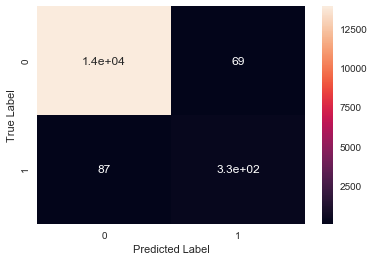

In [197]:
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_5_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_5_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [198]:
precision = precision_score(test_engine_data["within_5_days"], predictions)
recall = recall_score(test_engine_data["within_5_days"], predictions)
roc = roc_auc_score(test_engine_data["within_5_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 82.83582089552239%
Recall: 79.28571428571428%
ROC: 0.8939625242520167


We see that upon closer investigation 98% accuracy as a bold statement was a bit of a reach and more appropriately we can
investigate how to improve our recall because that is the most important number. The recall in this case is when the engine 
will fail within the given time window and we accurately predicted it would. Unfortunately, we only have a limited number of 
observations for failure while we have many more for non failure, thus our set is heavily skewed towards being more accurate
at predicting non failure. The ROC_AUC score may be the best estimate for a classifier and it looks like our best ROC score is 
situated with our within 15 day estimate. That looks to be the time that the sensors most trend towards a telling sign of 
failure.

We attempted to use logistic regression in this case which is still sensitive to non normalized data. let's normalize our 
data set and see if that makes any difference

In [210]:
normalized_copy = new_engine_data.copy()
normalized_copy[key_columns] = normalized_copy[key_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [212]:
num_test_engines = int(np.ceil(.3 * len(unique_engines)))
num_train_engines = int(len(unique_engines) - num_train_engines)

train_engines = np.random.choice(unique_engines,num_train_engines, replace = False)
test_engines = [x for x in unique_engines if x not in train_engines]

train_engine_data = normalized_copy.loc[normalized_copy["engine_id"].isin(train_engines),:]
test_engine_data = normalized_copy.loc[normalized_copy["engine_id"].isin(test_engines),:]

[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

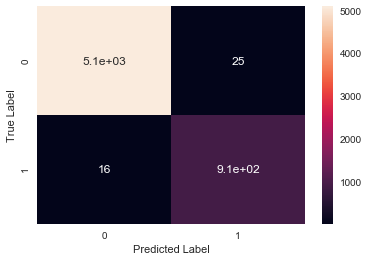

In [213]:
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_30_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_30_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [214]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
precision = precision_score(test_engine_data["within_30_days"], predictions)
recall = recall_score(test_engine_data["within_30_days"], predictions)
roc = roc_auc_score(test_engine_data["within_30_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 97.33759318423854%
Recall: 98.27956989247312%
ROC: 0.9889550118622092


[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

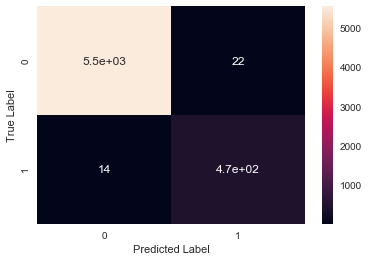

In [215]:
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_15_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_15_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [216]:
precision = precision_score(test_engine_data["within_15_days"], predictions)
recall = recall_score(test_engine_data["within_15_days"], predictions)
roc = roc_auc_score(test_engine_data["within_15_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 95.49180327868852%
Recall: 97.08333333333333%
ROC: 0.983440737081612


[Text(34,0.5,'True Label'), Text(0.5,16,'Predicted Label')]

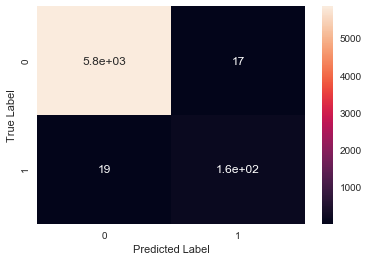

In [217]:
lr = LogisticRegression()
lr.fit(train_engine_data[key_columns], train_engine_data["within_5_days"])
predictions = lr.predict(test_engine_data[key_columns])
conf_array = confusion_matrix(test_engine_data["within_5_days"], predictions)
conf_df = pd.DataFrame(conf_array, index = range(2), columns = range(2))
plt.figure()
thing = sns.heatmap(conf_df, annot=True)
thing.set(xlabel = 'Predicted Label', ylabel = 'True Label')

In [218]:
precision = precision_score(test_engine_data["within_5_days"], predictions)
recall = recall_score(test_engine_data["within_5_days"], predictions)
roc = roc_auc_score(test_engine_data["within_5_days"], predictions)

print("Precision: " + str(precision*100) + "%")
print("Recall: "+ str(recall*100) + "%")
print("ROC: "+ str(roc))

Precision: 90.4494382022472%
Recall: 89.44444444444444%
ROC: 0.9457734409029791


Here we see that normalization makes a large difference. This puts a balance on terms that have smaller nominal values with the
terms that have larger values. It won't make much difference in the analysis above where we looked at the continuous value
because a random forest does not necessarily perform more consistently with normalized values. However, now that we have
normalized values we can look into applying a nueral network to see if that makes any improvement on our data. First 
lets do some cross validation to make sure that our results are consistent across all engines and not over fitting on this 
single train/test split

In [220]:
all_X = normalized_copy[key_columns]

In [224]:
lr = LogisticRegression()
all_Y = normalized_copy["within_30_days"]
scores = cross_val_score(lr,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(lr, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.30203671555311%
Precision: 97.82160461358082%
Recall: 97.54838709677418%
ROC: 0.999706528872489


In [225]:
lr = LogisticRegression()
all_Y = normalized_copy["within_15_days"]
scores = cross_val_score(lr,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(lr, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.27780486384322%
Precision: 95.70151832704215%
Recall: 94.99999999999999%
ROC: 0.9994437018189435


In [226]:
lr = LogisticRegression()
all_Y = normalized_copy["within_5_days"]
scores = cross_val_score(lr,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(lr,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(lr, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.20024555945093%
Precision: 89.37078539611193%
Recall: 82.5%
ROC: 0.9981471110865305


Across the board these numbers are quite high and quite similar. We are looking for maximum recall while still maximizing the
life of our engines. This would be a matter of call on the part of the engine owner, do they risk pushing the extra 15 days
despite the 2.5% increase in missed failure catches?

Let's now attempt to use a neural network and see how that compares with our above approaches

In [230]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
all_Y = normalized_copy["within_30_days"]
scores = cross_val_score(clf,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(clf, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.25841092786527%
Precision: 98.1561865057006%
Recall: 97.38709677419357%
ROC: 0.9997236381956739


In [231]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
all_Y = normalized_copy["within_15_days"]
scores = cross_val_score(clf,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(clf, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.26325823760835%
Precision: 95.64696167112514%
Recall: 95.5%
ROC: 0.9994394343145168


In [232]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
all_Y = normalized_copy["within_5_days"]
scores = cross_val_score(clf,all_X, all_Y, cv = 10, scoring = 'accuracy')
accuracy = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'roc_auc')
roc = scores.mean()
scores = cross_val_score(clf,all_X , all_Y, cv= 10, scoring = 'precision')
precision = scores.mean()
scores = cross_val_score(clf, all_X, all_Y, cv = 10, scoring = 'recall')
recall = scores.mean()
print("Accuracy: "+ str(accuracy * 100) + "%")
print("Precision: "+str(precision * 100) + "%")
print("Recall: "+str(recall*100) + "%")
print("ROC: "+str(roc))

Accuracy: 99.2002502564565%
Precision: 87.80394431599767%
Recall: 84.50000000000001%
ROC: 0.997964906847978


Similar results here with a neural network to logistic regression. With the computational energy spent to create this 
it is probably not worth the time to create a neural network in this case as logistic regression performs just fine.